# Logistic growth models of SARS-CoV-2 strain ratios

This notebook explores multivariate logistic growth models, with applications to determining the relative proportions of SARS-CoV-2 strains over time.

**WARNING**: The purpose of this tutorial is to demonstrate Pyro's modeling and inference syntax. 
Making reliable inferences about SARS-CoV-2 **is not** the purpose of this tutorial.

#### Table of contents

* [Overview](#Overview)
* [Loading data](#Loading-data)
* [A First Model](#A-first-model)
* [Defining a regional model](#Defining-a-regional-model)
* [Defining an alternative regional model](#Defining-an-alternative-regional-model)

## Overview <a name="Overview" />

When different strains/lineages/variants of a virus like SARS-CoV-2 circulate in a population, those lineages that have the largest fitness will tend to dominate, and those lineages that are least fit will tend to be outcompeted by the fittest lineages.
In this tutorial we set out to infer (differential) growth rates for different 
SARS-CoV-2 lineages using a spatio-temporal dataset of SARS-CoV-2 genetic sequences.
We'll start with the simplest possible model and then move on to more complex models with hierarchical structure.

In [1]:
import os
from functools import partial

import numpy as np
import torch

import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import ClippedAdam

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using GPU")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("Using CPU")
    
smoke_test = ('CI' in os.environ)  # for use in continuous integration testing

Using CPU


## Loading data <a name="Loading-data" />

Our data consist of a few million genetic sequences of SARS-CoV-2 viruses, clustered into [PANGO lineages](https://cov-lineages.org), and aggregated into a few hundred regions globally and into 28-day time bins. Preprocessing was performed by Nextstrain's [ncov](https://docs.nextstrain.org/projects/ncov/en/latest/reference/remote_inputs.html) tool, and aggregation was performed by the Broad Institute's [pyro-cov](https://github.com/broadinstitute/pyro-cov/blob/master/scripts/preprocess_nextstrain.py) tool.

In [2]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts
dataset = load_nextstrain_counts()

def summarize(x, name=""):
    if isinstance(x, dict):
        for k, v in sorted(x.items()):
            summarize(v, name + "." + k if name else k)
    elif isinstance(x, torch.Tensor):
        print(f"{name}: {type(x).__name__} of shape {tuple(x.shape)} on {x.device}")
    elif isinstance(x, list):
        print(f"{name}: {type(x).__name__} of length {len(x)}")
    else:
        print(f"{name}: {type(x).__name__}")
summarize(dataset)

counts: Tensor of shape (27, 202, 1316) on cpu
features: Tensor of shape (1316, 2634) on cpu
lineages: list of length 1316
locations: list of length 202
mutations: list of length 2634
sparse_counts.index: Tensor of shape (3, 57129) on cpu
sparse_counts.total: Tensor of shape (27, 202) on cpu
sparse_counts.value: Tensor of shape (57129,) on cpu
start_date: datetime
time_step_days: int


The main two pieces of data are a counts tensor and a feature matrix. The `dataset["counts"]` tensor has shape (T, R, L) where `T` is the number of time bins, `R` is the number of regions, and `L` is the number of strains or PANGO lineages, and `dataset["counts"][t,r,l]` is the number of samples in the corresponding time-region-location bin.

The `dataset["features"]` matrix (not used in this tutorial) has shape (L, M) where `L` is the number of strains or PANGO lineages, and `M` is the number of mutations, and `dataset["features"][l,m]` is the portion of samples classified as lineage `l` that exhibit mutation `m` (note this is not quite binary, because each lineage is heterogeneous).

The count data are heavily skewed towards a few large regions and dominant lineages like `B.1.1.7` and `B.1.617.2`.

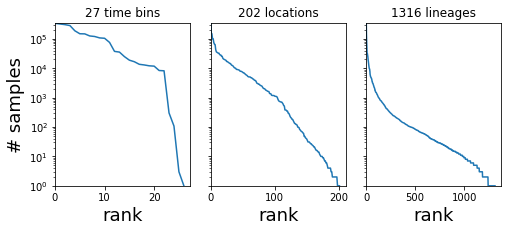

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
for i, name in enumerate(["time bin", "location", "lineage"]):
    counts = dataset["counts"].sum(list({0, 1, 2} - {i}))
    Y = counts.sort(0, True).values
    axes[i].plot(Y)
    axes[i].set_xlim(0, None)
    axes[0].set_ylim(1, None)
    axes[i].set_yscale("log")
    axes[i].set_xlabel(f"rank", fontsize=18)
    axes[i].set_title(f"{len(Y)} {name}s")
axes[0].set_ylabel("# samples", fontsize=18)
plt.subplots_adjust(wspace=0.15);

## Helpers for manipulating data

In [4]:
def get_lineage_id(s):
    """Get lineage id from string name"""
    return np.argmax(np.array([s]) == dataset['lineages'])

def get_location_id(s):
    """Get location id from string name"""
    return np.argmax(np.array([s]) == dataset['locations'])

def get_aggregated_counts_from_locations(locations):
    """Get aggregated counts from a list of locations"""
    return sum([dataset['counts'][:, get_location_id(loc)] for loc in locations])

## A first model

First let's zoom-in on Massachusetts and a few surrounding states:

In [5]:
northeast_states = ['USA / Massachusetts', 
                    'USA / New York', 
                    'USA / Connecticut', 
                    'USA / New Hampshire',
                    'USA / Vermont',
                    'USA / New Jersey',
                    'USA / Maine',
                    'USA / Rhode Island', 
                    'USA / Pennsylvania']

northeast_counts = get_aggregated_counts_from_locations(northeast_states)

Next let's extract sublineages corresponding to Alpha and Delta:

In [6]:
# The Alpha and Delta lineages consist of many sublineages, which we need to aggregate.
Q_lineages = [lin for lin in dataset['lineages'] if lin[:2] == 'Q.']
AY_lineages = [lin for lin in dataset['lineages'] if lin[:3] == 'AY.']

alpha_lineages = ['B.1.1.7'] + Q_lineages
delta_lineages = ['B.1.617.2'] + AY_lineages

alpha_ids = [get_lineage_id(lin) for lin in alpha_lineages]
delta_ids = [get_lineage_id(lin) for lin in delta_lineages]

alpha_counts = northeast_counts[:, alpha_ids].sum(-1)
delta_counts = northeast_counts[:, delta_ids].sum(-1)

In [7]:
# Let's combine the counts into a single tensor
alpha_delta_counts = torch.stack([alpha_counts, delta_counts]).T
print(alpha_delta_counts.shape)

torch.Size([27, 2])


Next let's plot the time series of count proportions (Alpha vs. Delta):

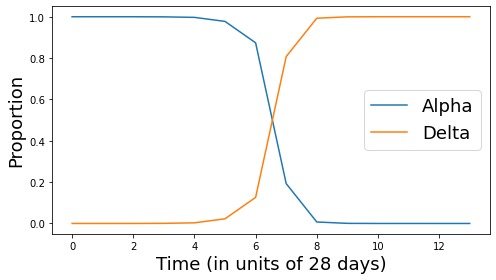

In [8]:
# We skip the first year or so of the pandemic where Alpha and Delta are not present
total_counts = alpha_counts + delta_counts
start_time = 13
total_counts = total_counts[start_time:]
plt.figure(figsize=(7, 4))
plt.plot(np.arange(total_counts.shape[0]), alpha_counts[start_time:] / total_counts, 
         label='Alpha')
plt.plot(np.arange(total_counts.shape[0]), delta_counts[start_time:] / total_counts, 
         label='Delta')
plt.xlabel("Time (in units of 28 days)", fontsize=18)
plt.ylabel("Proportion", fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

We see that at first Alpha was dominant, but then Delta started outcompeting it until Delta became dominant.

### Model definition

Instead of attempting to model how the total number of observed sequences varies as a function of time (which depends on complex human behavior), we instead model the *proportion* of sequences at each time step that are Alpha versus Delta. In other words if we observed 8 Alpha lineages and 2 Delta lineages at a given time step, we model the proportions 80% and 20% instead of the raw counts 8 and 2. To do this we use a Multinomial distribution.

In [9]:
def basic_model(counts):
    T, L = counts.shape

    # Define plates over lineage and time
    lineage_plate = pyro.plate("lineages", L, dim=-1)
    time_plate = pyro.plate("time", T, dim=-2)

    # Define a growth rate (i.e. slope) and an init (i.e. intercept) for each lineage
    with lineage_plate:
        rate = pyro.sample("rate", dist.Normal(0, 1))
        init = pyro.sample("init", dist.Normal(0, 1))

    # We measure time in units of the SARS-CoV-2 generation time of 5.5 days
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5
    
    # Assume lineages grow linearly in logit space
    logits = init + rate * time[:, None]
    
    # We use the softmax function (the multivariate generalization of the logit function)
    # to define normalized probabilities from the logits
    probs = torch.softmax(logits, dim=-1)
    assert probs.shape == (T, L)
    
    # Observe counts via a multinomial likelihood.
    with time_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(probs=probs.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

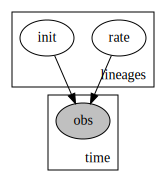

In [10]:
# Let's look at the graphical structure of our model
pyro.render_model(partial(basic_model, alpha_delta_counts))

### Define helper for fitting models

In [11]:
def fit_svi(model, lr=0.1, num_steps=1001, log_every=250):
    pyro.clear_param_store()  # clear parameters from previous runs
    pyro.set_rng_seed(20211214)
    if smoke_test:
        num_steps = 2
        
    # Define a mean field guide (i.e. variational distribution)
    guide = AutoNormal(model, init_scale=0.01)
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
    svi = SVI(model, guide, optim, Trace_ELBO())
    
    # Train (i.e. do ELBO optimization) for num_steps iterations
    losses = []
    for step in range(num_steps):
        loss = svi.step()
        losses.append(loss)
        if step % log_every == 0:
            print(f"step {step: >4d} loss = {loss:0.6g}")
            
    # Plot to assess convergence.
    plt.figure(figsize=(6, 3))
    plt.plot(losses)
    plt.xlabel("SVI step", fontsize=18)
    plt.ylabel("ELBO loss", fontsize=18)
    plt.tight_layout()

    return guide

### Let's fit `basic_model` and inspect the results

step    0 loss = 103782
step  250 loss = 3373.05
step  500 loss = 1299.14
step  750 loss = 524.81
step 1000 loss = 304.319
step 1250 loss = 278.005
step 1500 loss = 261.731


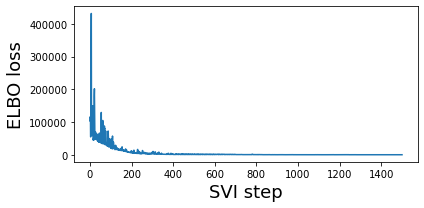

In [12]:
# We truncate the data to the period with non-zero counts
guide = fit_svi(partial(basic_model, alpha_delta_counts[13:]), num_steps=1501)

#### Let's inspect the posterior means of our latent parameters:

In [13]:
for k, v in guide.median().items():
    print(k, v.data.cpu().numpy())

rate [-0.27021623  0.27021623]
init [ 8.870546 -8.870401]


As expected the Delta lineage (corresponding to index `1`) has a differential growth rate advantage with respect to the Alpha lineage (corresponding to index `0`) :

In [14]:
print("Multiplicative advantage: {:.2f}".format(
      np.exp(guide.median()['rate'][1] - guide.median()['rate'][0])))

Multiplicative advantage: 1.72


This seems like it might be an overestimate. Can we get better estimates by modeling each spatial region individually?

## Defining a regional model

Instead of focusing on northeastern US states we now consider the entire global dataset.

In [15]:
# First extract the data we want to use
alpha_counts = dataset['counts'][:, :, alpha_ids].sum(-1)
delta_counts = dataset['counts'][:, :, delta_ids].sum(-1)
counts = torch.stack([alpha_counts, delta_counts], dim=-1)
print("counts.shape: ", counts.shape)
print("number of regions: {}".format(counts.size(1)))

counts.shape:  torch.Size([27, 202, 2])
number of regions: 202


In [16]:
# Model each region as multivariate logistic growth
def regional_model(counts):
    T, R, L = counts.shape
        
    # Now we also define a region plate in addition to the time/lineage plates
    lineage_plate = pyro.plate("lineages", L, dim=-1)
    region_plate = pyro.plate("region", R, dim=-2)
    time_plate = pyro.plate("time", T, dim=-3)

    # We use the same growth rate (i.e. slope) for each region
    with lineage_plate:
        rate = pyro.sample("rate", dist.Normal(0, 1))
        
    # We allow the init to vary from region to region
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    with region_plate, lineage_plate:
        init = pyro.sample("init", dist.Normal(0, init_scale))

    # We measure time in units of the SARS-CoV-2 generation time of 5.5 days
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5

    # Instead of using the softmax function we directly use the 
    # logits parameterization of the Multinomial distribution
    logits = init + rate * time[:, None, None]
    
    # Observe sequences via a multinomial likelihood.
    with time_plate, region_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

step    0 loss = 909278
step  250 loss = 509502
step  500 loss = 630927
step  750 loss = 501493
step 1000 loss = 1.04533e+06
step 1250 loss = 1.98151e+06
step 1500 loss = 328504
step 1750 loss = 279016
step 2000 loss = 310281
step 2250 loss = 217622
step 2500 loss = 204381
step 2750 loss = 176877
step 3000 loss = 152123


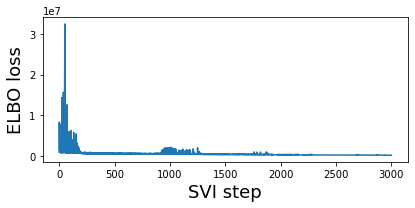

In [17]:
guide = fit_svi(partial(regional_model, counts), num_steps=3001)

In [18]:
print("Multiplicative advantage: {:.2f}".format(
      np.exp(guide.median()['rate'][1] - guide.median()['rate'][0])))

Multiplicative advantage: 1.17


## Defining an alternative regional model

The regional model we defined above assumed that the `rate` for each lineage did not vary between regions. Here we add additional hierarchical structure and allow the rate to vary from region to region.

In [19]:
def regional_model2(counts):
    T, R, L = counts.shape
    
    lineage_plate = pyro.plate("lineages", L, dim=-1)
    region_plate = pyro.plate("region", R, dim=-2)
    time_plate = pyro.plate("time", T, dim=-3)

    # We assume the init can vary a lot from region to region but
    # that the rate varies considerably less.
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4, 2))
    
    # As before each lineage has a latent growth rate
    with lineage_plate:
        rate_lineage = pyro.sample("rate", dist.Normal(0, 1))
        
    # We allow the rate and init to vary from region to region
    with region_plate, lineage_plate:
        # The per-region per-lineage rate is governed by a hierarchical prior
        rate_region_lineage = pyro.sample("rate_region_lineage", 
                                          dist.Normal(rate_lineage, rate_scale))
        init = pyro.sample("init", dist.Normal(0, init_scale))

    # We measure time in units of the SARS-CoV-2 generation time of 5.5 days
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5

    logits = init + rate_region_lineage * time[:, None, None]
    
    # Observe sequences via a multinomial likelihood.
    with time_plate, region_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )

step    0 loss = 2.14938e+06
step  250 loss = 1.44383e+06
step  500 loss = 1.24946e+06
step  750 loss = 698431
step 1000 loss = 614089
step 1250 loss = 505670
step 1500 loss = 433675
step 1750 loss = 434513
step 2000 loss = 382355
step 2250 loss = 334707
step 2500 loss = 300050
step 2750 loss = 280347
step 3000 loss = 261445


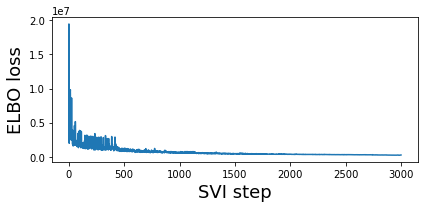

In [20]:
guide = fit_svi(partial(regional_model2, counts), num_steps=3001)

In [21]:
print("Multiplicative advantage: {:.2f}".format(
      np.exp(guide.median()['rate'][1] - guide.median()['rate'][0])))

Multiplicative advantage: 1.14
